# Logistic Regression with a Neural Network mindset

로지스틱 회귀 분류(logistic regression classifier) 만들기.   
고양이 or not 고양이 이미지 분류.

**You will learn to:**
- Initializing parameters 
- Calculating the cost function and its gradient 
- Using an optimization algorithm (gradient descent) 


## DataSetting ##
### 01-1. 데이터 확인하기

In [35]:
from lr_utils import load_dataset
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [36]:
print('학습 데이터 : ',train_set_x_orig.shape)
# 209개 데이터, 64x64(이미지 가로세로), 3개 채널(RGB)

print('학습 데이터(라벨) : ',train_set_y.shape)
# 1행 209열 > 209개 데이터 라벨

print('\n테스트 데이터 : ',test_set_x_orig.shape)
# 50개
print('테스트 데이터(라벨) : ',test_set_y.shape)

print('\n라벨 갯수 : ',classes.shape)
print('라벨 : ',classes[0].decode("utf-8"),"/",classes[1].decode("utf-8"))

학습 데이터 :  (209, 64, 64, 3)
학습 데이터(라벨) :  (1, 209)

테스트 데이터 :  (50, 64, 64, 3)
테스트 데이터(라벨) :  (1, 50)

라벨 갯수 :  (2,)
라벨 :  non-cat / cat


y = [1], it's a 'cat' picture.


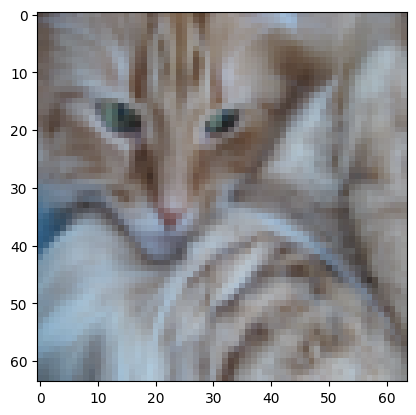

In [34]:
# Example of a picture
import matplotlib.pyplot as plt
import numpy as np

index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

### 01-2. 이미지 데이터 평탄화 작업   
(num_px, num_px, 3)를 (num_px * num_px * 3, 1)형태의 단일 벡터로 변환 -> 각 열(column)이 하나의 이미지 벡터가 되는 형태로 정리됨.   
*ML알고리즘은 1차원 벡터 형태의 입력을 처리할 수 있음. 이미지를 평탄화하여 각 픽셀값을 하나의 긴 벡터로 변환하여 계산함.

**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

In [44]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
# 209개 데이터 기준으로 reshape함. 64*64*3 = 12288차원 벡터로 변환. -> 209 데이터는 각 12288개 차원(벡터)을 가짐
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)

# print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
# print ("train_set_y shape: " + str(train_set_y.shape))
# print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
# print ("test_set_y shape: " + str(test_set_y.shape))
# print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

In [40]:
train_set_x_flatten.shape

(209, 12288)

### 01-3.정규화>표준화
픽셀값은 0-255 사이의 값을 가지고, 세 개의(RGB) 숫자로 이뤄진 벡터가 됨.

In [45]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [47]:
train_set_x.shape

(209, 12288)

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

>> Q.flatten 작업할 때 왜 전치시키는걸까?

## 모델 구현

In [48]:
def propagate(w, b, X, Y):
    m = X.shape[1]          # number of examples : m = 데이터 샘플수

    z = np.dot(w.T, X) + b
    A = 1 / (1 + np.exp(-z))            # sigmoid
    L = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # cost function 구함 : 실제값과 예측값의 차이 구함. log함수 사용했넹 > convex > 로지스틱 함수는 지수함수에 상극이 되는 로그 함수를 빋용함수에 사용함. > 예측값이 실제값에서 멀어질수록 높은 cost를 가지도록 됨.

    dw = (1 / m) * np.dot(X, (A - Y).T)                 # 미분값 수식 유도하는 거 손으로 작성해보기
    db = (1 / m) * np.sum(A - Y)

    cost = np.squeeze(L)                         # squeeze()는 불필요한 차원을 제거하는 역할을 함.   >>>>>>>>>>>>>>>>>>> cost.shape는 (209,1)???? >>>>>>> 스칼라 값이 되넹? 입력 값이 2X2라서 그런 거 같음

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw  # 파라미터 갱신
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("##### Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# GRADED FUNCTION: predict

def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))             ##############Y_prediction에 결과값 넣는 거
    w = w.reshape(X.shape[0], 1)                # initialize_with_zeros() 에서 작업했던 거

    z = np.dot(w.T, X) + b
    A = 1 / (1 + np.exp(-z))            # sigmoid
  
    for i in range(A.shape[1]):         # 데이터 수 만큼 for문
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=True):
    """
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    info -- dictionary containing information about the model.
    """
    
    # 파라미터 초기화
    w = np.zeros(shape=(X_train.shape[0], 1))
    b = 0

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)         # epoch
    
    w = parameters["w"]
    b = parameters["b"]
    
    # 모델 학습시킨 w,b 기반으로 테스트하기.
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [80]:
num_iterations = 250
learning_rate = 0.005

result = model(train_set_x.T, train_set_y, test_set_x.T, test_set_y, num_iterations, learning_rate, print_cost = True)

##### Cost after iteration 0: 0.693147
##### Cost after iteration 100: 0.584508
##### Cost after iteration 200: 0.466949
train accuracy: 85.16746411483254 %
test accuracy: 80.0 %


/tmp/ipykernel_2420901/1234060810.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


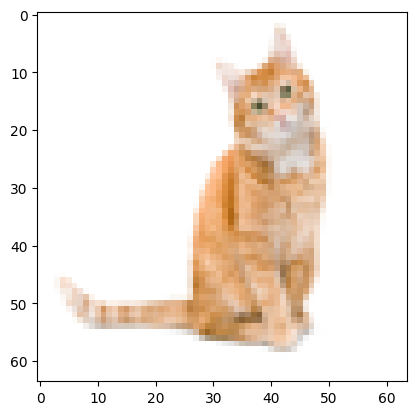

y = 1.0, your algorithm predicts a "cat" picture.


In [83]:
import imageio
from PIL import Image

num_px = 64

my_image = "catmaybe.jpg"   # change this to the name of your image file 
fname = "images/" + my_image
image = np.array(imageio.imread(fname))
image_pil = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
image_resized = image_pil.resize((num_px, num_px))  # 이미지 리사이즈
image_resized = np.array(image_resized)  # 다시 numpy 배열로 변환

# 이미지 평탄화 및 전처리
my_image = image_resized.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(result["w"], result["b"], my_image)

plt.imshow(image_resized)
plt.show()

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

> 결과 분석   
>> epoch(num_iterations)이 250 이상 되면 오히려 성능이 떨어짐.

---

## General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

---

## Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 02-1. Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.   
시그모이드 함수 만들기

In [7]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [8]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


**Expected Output**: 

<table style="width:20%">
  <tr>
    <td>**sigmoid(0)**</td>
    <td> 0.5</td> 
  </tr>
  
  <tr>
    <td>**sigmoid(9.2)**</td>
    <td> 0.999898970806 </td> 
  </tr>
</table>

### 02-2.Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.   
초기 파라미터 설정하기    
> bias도 w처럼 벡터 형태가 아니라 스칼라값??

In [9]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros(shape=(dim, 1))
    b = 0


    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))          # isinstance(인스턴스, 클래스/데이터타입) -> bool
    
    return w, b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 02-3.Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [11]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]          # number of examples : m = 데이터 샘플수

    A = sigmoid(np.dot(w.T, X) + b)  # z값 구해서 시그모이드 함수까지 활용함. A > 예측값
    L = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # cost function 구함 : 실제값과 예측값의 차이 구함. log함수 사용했넹 > convex > 로지스틱 함수는 지수함수에 상극이 되는 로그 함수를 빋용함수에 사용함. > 예측값이 실제값에서 멀어질수록 높은 cost를 가지도록 됨.

    dw = (1 / m) * np.dot(X, (A - Y).T)                 # 미분값 수식 유도하는 거 손으로 작성해보기
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(L)                         # squeeze()는 불필요한 차원을 제거하는 역할을 함.   >>>>>>>>>>>>>>>>>>> cost.shape는 (209,1)???? >>>>>>> 스칼라 값이 되넹? 입력 값이 2X2라서 그런 거 같음
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### d) Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [13]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps ( True or False )
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw  # 파라미터 갱신
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("##### Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = True)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

##### Cost after iteration 0: 6.000065
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.1124579 ]
 [ 0.23106775]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.90158428]
 [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.430462071679 </td>
    </tr>

</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [22]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))             ##############Y_prediction에 결과값 넣는 거
    w = w.reshape(X.shape[0], 1)                # initialize_with_zeros() 에서 작업했던 거

    A = sigmoid(np.dot(w.T, X) + b)

    
    for i in range(A.shape[1]):         # 데이터 수 만큼 for문
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [16]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

---

## Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [17]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=True):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])                    # 0으로 초기화

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)         # epoch
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [40]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 100, learning_rate = 0.005, print_cost = True)

##### Cost after iteration 0: 0.693147
train accuracy: 67.94258373205741 %
test accuracy: 84.0 %


In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = True)

##### Cost after iteration 0: 0.693147
##### Cost after iteration 100: 0.584508
##### Cost after iteration 200: 0.466949
##### Cost after iteration 300: 0.376007
##### Cost after iteration 400: 0.331463
##### Cost after iteration 500: 0.303273
##### Cost after iteration 600: 0.279880
##### Cost after iteration 700: 0.260042
##### Cost after iteration 800: 0.242941
##### Cost after iteration 900: 0.228004
train accuracy: 96.65071770334929 %
test accuracy: 72.0 %


In [20]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

##### Cost after iteration 0: 0.693147
##### Cost after iteration 100: 0.584508
##### Cost after iteration 200: 0.466949
##### Cost after iteration 300: 0.376007
##### Cost after iteration 400: 0.331463
##### Cost after iteration 500: 0.303273
##### Cost after iteration 600: 0.279880
##### Cost after iteration 700: 0.260042
##### Cost after iteration 800: 0.242941
##### Cost after iteration 900: 0.228004
##### Cost after iteration 1000: 0.214820
##### Cost after iteration 1100: 0.203078
##### Cost after iteration 1200: 0.192544
##### Cost after iteration 1300: 0.183033
##### Cost after iteration 1400: 0.174399
##### Cost after iteration 1500: 0.166521
##### Cost after iteration 1600: 0.159305
##### Cost after iteration 1700: 0.152667
##### Cost after iteration 1800: 0.146542
##### Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 
    
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

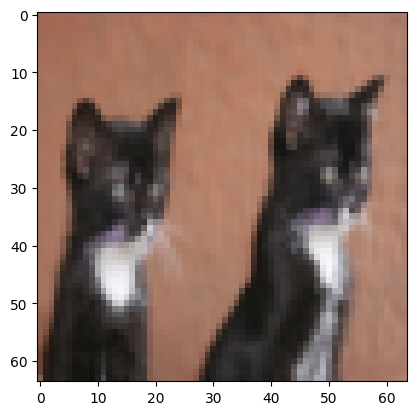

In [41]:
# Example of a picture that was wrongly classified.
index = 0
num_px = 64
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0, index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0, index]].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



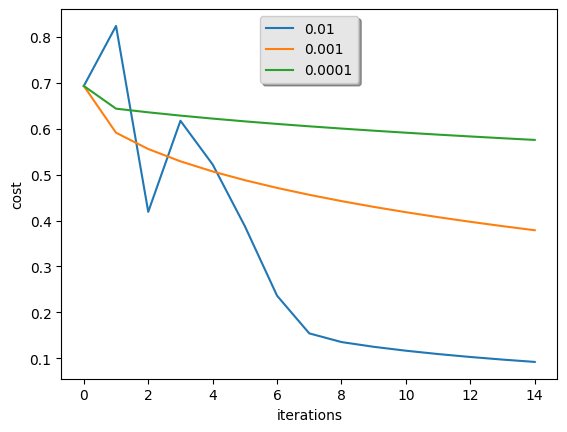

In [42]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


## 7 - Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [43]:
import imageio
from PIL import Image

num_px = 64

In [50]:
my_image = "catmaybe.jpg"   # change this to the name of your image file 
fname = "images/" + my_image
image = np.array(imageio.imread(fname))
image_pil = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
image_resized = image_pil.resize((num_px, num_px))  # 이미지 리사이즈
image_resized = np.array(image_resized)  # 다시 numpy 배열로 변환

# 이미지 평탄화 및 전처리
my_image = image_resized.reshape((1, num_px * num_px * 3)).T

/tmp/ipykernel_2116152/2436137979.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


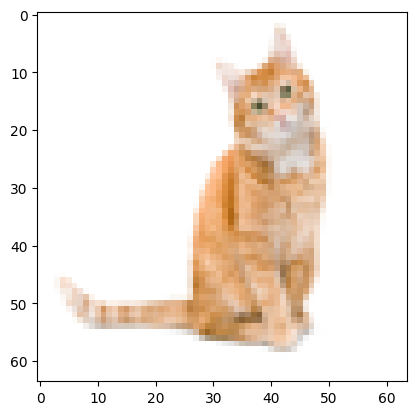

y = 1.0, your algorithm predicts a "cat" picture.


In [51]:
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image_resized)
plt.show()

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<font color='blue'>
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c